# **Azure voor tekst generation**

In [3]:
import pandas as pd
from openai import AzureOpenAI
import os
from dotenv import load_dotenv
load_dotenv()

import glob
import re

In [4]:
# Zoek alle tuin_feedback_*.csv bestanden in de huidige directory
feedback_files = glob.glob("tuin_feedback_*.csv")

# Toon beschikbare bestanden en vraag om gebruikers-id
print("Beschikbare tuin feedback bestanden:")
for idx, file in enumerate(feedback_files):
    print(f"{idx}: {file}")

# Input voor gebruikers-id (index van het bestand)
file_idx = int(input("Voer het nummer in van het gewenste gebruikersbestand: "))
tuinen_feedback = pd.read_csv(feedback_files[file_idx])

# De Tuinen DataFrame inlezen
tuinen_df = pd.read_csv("tuinen.csv")

# Filter tuinen_df op basis van de feedback die zijn geliked
liked_tuinen = tuinen_feedback[tuinen_feedback['Beoordeling'] == 'like']['Tuin_ID'].unique()
tuinen_df_liked = tuinen_df[tuinen_df['id'].isin(liked_tuinen)]
tuinen_df_liked.to_csv("liked_tuinen.csv", index=False)

# Lees het weerbestand in
weer_df = pd.read_csv(file)

# Gerbruiker dataframe inlezen
gebruikers_df = pd.read_csv("Geb_data.csv").iloc[-1:]

Beschikbare tuin feedback bestanden:
0: tuin_feedback_248170.csv


# **Azure aanhalen**

In [5]:
# Variabelen ophalen
endpoint = os.getenv("AZURE_ENDPOINT")
model_name = os.getenv("AZURE_MODEL_NAME")
deployment = os.getenv("AZURE_DEPLOYMENT")
subscription_key = os.getenv("AZURE_SUBSCRIPTION_KEY")
api_version = os.getenv("AZURE_API_VERSION")

# Voorbeeld: veilig printen (optioneel voor debuggen)
def mask(value, start=5, end=5):
    if value:
        return value[:start] + "..." + value[-end:]
    return "❌ NIET gevonden"

print("Endpoint:", endpoint)
print("Model name:", model_name)
print("Deployment:", deployment)
print("Subscription key:", mask(subscription_key))
print("API version:", api_version)

Endpoint: https://satsj-mayata9x-swedencentral.cognitiveservices.azure.com/
Model name: gpt-4o
Deployment: gpt-4o
Subscription key: 6f9bk...Gb0e9
API version: 2024-12-01-preview


# **GPT-4o model voor advies**

In [6]:
# Variabelen ophalen
endpoint = os.getenv("AZURE_ENDPOINT")
model_name = os.getenv("AZURE_MODEL_NAME")
deployment = os.getenv("AZURE_DEPLOYMENT")
subscription_key = os.getenv("AZURE_SUBSCRIPTION_KEY")
api_version = os.getenv("AZURE_API_VERSION")

# OpenAI client
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

# Eerste 10 rijen van elke CSV als tekst
gebruikers_csv_data = gebruikers_df.to_string(index=False)
tuinen_csv_data = tuinen_df.to_string(index=False)
weer_csv_data = weer_df.to_string(index=False)

# Gebruikersvraag
org = "Ik wil een gezellige tuin met verwelkomend sfeer en planten die goed tegen droogte kunnen."

toevoeging = (
    "Ik als gebruiker wil een gezellige tuin hebben op basis van de adviezen en de voorkeuren "
    "die ik meegeef in deze app. Geef mij een tuin die volledig zal voldoen aan mijn wensen en eisen."
)

gebruikersvraag = f"{org} {toevoeging}"

# Prompt
plantadvies_prompt = f"""
Je bent een geavanceerde tuinadviseur. Je taak is om gebruikers te adviseren over geschikte planten op basis van:
- Hun voorkeuren
- Tuinen die ze mooi vinden
- Het lokale klimaat (weerdata)

Gebruik de volgende data als basis voor je advies.

### Gebruikersvoorkeuren (CSV):
{gebruikers_csv_data}

### Favoriete tuinen van de gebruiker (CSV):
{tuinen_csv_data}

### Weerdata (CSV):
{weer_csv_data}

### Vraag van de gebruiker:
"{gebruikersvraag}"

### Richtlijnen voor je advies:
- Geef een lijst van geschikte planten met uitleg per plant (bv. lichtbehoefte, bodem, onderhoud, klimaatbestendigheid).
- Geef suggesties voor combinaties (visueel of functioneel).
- Laat zien hoe deze planten passen bij het klimaat van de gebruiker.
- Wees concreet, inspirerend en onderbouwd.
- Geef een plan van aanpak voor het aanleggen van de tuin.
- Gebruik de stijl van een deskundige tuinontwerper.
- Maak de teksten leesbaar en aantrekkelijk en niet te lang.
- Gebruik de volgende structuur:
  1. Introductie van de tuin en de sfeer.
  2. Lijst van planten met uitleg.
  3. Welke passen bij het klimaat.
  4. Combinaties en hoe ze passen bij de tuin.
  5. Aanlegplan en onderhoudstips.

Begin het advies met een korte samenvatting van de situatie en geef daarna het gedetailleerde plantenplan.
"""

# Aanroep naar GPT
response = client.chat.completions.create(
    messages=[
        {"role": "system", "content": "Je bent een deskundige tuinadviseur."},
        {"role": "user", "content": plantadvies_prompt}
    ],
    max_tokens=4096,
    temperature=0.9,
    top_p=1.0,
    model=deployment
)

volledige_plantadvies = response.choices[0].message.content

# Output tonen
print("\n🌿 Tuinadvies:\n")
print(volledige_plantadvies)


🌿 Tuinadvies:

### Samenvatting van de situatie:
Gebruiker Sven (23 jaar, woont in Zuid-Holland in een appartement) heeft een sterke voorkeur voor een bohemian stijl tuin die een gezellige en verwelkomende sfeer uitstraalt. Zijn tuin moet droogtebestendige planten bevatten en mag een gemiddelde hoeveelheid onderhoud vragen. Hij houdt van natuurlijke en klassieke tuinen, met planten die bijen en vlinders aantrekken. Hij heeft een allergie voor graspollen en een hond, en zijn budget is €2500. 

Gezien zijn voorkeuren, woningtype en lokale omstandigheden, stellen we een droogtebestendige bohemian tuin samen die biodiversiteit bevordert, onderhoudsvriendelijk is en zowel visueel aantrekkelijk als functioneel.

---

### Advies voor Sven's Bohemian Tuin

#### 1. **Introductie van de tuin en de sfeer**
De tuin die we voor ogen hebben combineert de organische vormen van een natuurlijke tuin met de nostalgische charme van een klassieke stijl. Door droogtebestendige planten te gebruiken, creëre

# **Promt voor het maken van de afbeeldingen**

In [7]:
# Prompt om visuele sfeer en elementen per seizoen te extraheren, met nadruk op zichtbaarheid van de tuin en balans in groen
visual_prompt = f"""
Je bent een creatieve tuinontwerper en visueel kunstenaar gespecialiseerd in seizoensgebonden tuinbeelden.

Hieronder vind je een uitgebreid tuinadvies voor een **kleine Nederlandse achtertuin**, gericht op een onderhoudsarme mediterrane sfeer:
\"\"\"
{volledige_plantadvies}
\"\"\"

Beschrijf per seizoen (lente, zomer, herfst, winter) in 1-2 zinnen hoe deze compacte achtertuin er visueel uitziet.

Voor elk seizoen moeten de volgende visuele elementen duidelijk naar voren komen:
- Geef mij de een duidelijke visuele beschrijving van de tuin.
- De kleuren van bloemen, bladeren en lucht
- Het type planten of bomen dat in bloei of rust is
- Seizoensgebonden veranderingen zoals bloesems, vallende bladeren, winterrust of felle zon
- De interactie van licht en schaduw (bijv. zachte ochtendzon in de lente, lange schaduwen in de herfst)
- De sfeer en uitstraling van de tuin: levendig, verstild, zonnig, knus, enz.
- Typische mediterrane elementen die passen in een Nederlandse tuin: lavendel, rozemarijn, kleine olijf- of vijgenboom in pot, grindpaadjes, houten meubels, terracotta potten

Let op: de tuin is compact (ca. 5 bij 3 meter), volledig ommuurd of omheind, en grenst aan de achterzijde van een Nederland
se rijtjeswoning met een kleine terrasdeur of schuifpui. Houd rekening met beperkte ruimte en het Nederlandse klimaat.

Geef vier korte, krachtige en visueel rijke beschrijvingen die geschikt zijn als input voor AI-beeldgenerators zoals RunwayML of Stable Diffusion. Nummer ze duidelijk:

1. Lente: ...
2. Zomer: ...
3. Herfst: ...
4. Winter: ...
"""

response_visual = client.chat.completions.create(
    messages=[
        {"role": "system", "content": "Je bent een creatieve tuinontwerper en AI-kunstprompter."},
        {"role": "user", "content": visual_prompt}
    ],
    max_tokens=300,
    temperature=0.8,
    top_p=1.0,
    model=deployment
)
visual_descriptions = response_visual.choices[0].message.content

print("\n🎨 Visual prompts voor beeldgenerator per seizoen:\n")
print(visual_descriptions)


🎨 Visual prompts voor beeldgenerator per seizoen:

### 1. **Lente:**  
De compacte tuin ontwaakt uit zijn winterslaap met een explosie van zachtgele sleutelbloemen en paarse veldsalie. Terracotta potten gevuld met aromatische lavendel en rozemarijn staan langs het grindpaadje, dat glinstert in de zachte ochtendzon. De lucht is fris en helder, en de hoekjes van de tuin baden in een zacht spel van licht en schaduw. Kleine bijen fladderen rond tussen de bloemen, terwijl de mediterrane sfeer wordt versterkt door een houten bankje met warme kussens in pastelkleuren.  

---

### 2. **Zomer:**  
Onder een strakblauwe hemel straalt de tuin in een mediterraan kleurenpalet: de paarse tinten van wilde marjolein contrasteren met het goudgeel van boerenwormkruid. Het grindpaadje warmt op in de zon, terwijl de terracotta potten een zongebleekte uitstraling krijgen. Een kleine, potgekweekte olijfboom in de hoek vangt het licht, en de hele tuin ruikt naar lavendel en rozemarijn. Schaduwen van de omhe

# **Model runwayml/stable-diffusion-v1-5 gebruikt voor beeld generatie**

In [45]:
visual_descriptions = ("""
A top-down view colorful garden plan on an A4 sheet with light grey grid lines in the background.
It shows a small Dutch backyard designed for biodiversity and family-friendliness.
The layout includes vibrant, clearly distinguishable plants arranged harmoniously for natural balance.
Paths are shown with simple geometric shapes. Plants are grouped thoughtfully by sun and shade needs.
Use rich colors and subtle textures for plants: lavender (purple), salvia (blue), hosta (green), ferns (dark green), rosemary (grey-green), oregano (light green), roses (red), bamboo (yellow-green). Include a small seating area with a wooden table and two chairs, a hammock, and a small water feature like a pond or fountain. Add a clear, neat legend in the corner with plant names and characteristics such as sun/shade preference, height, and flowering season. The style should be a professional, hand-drawn architectural illustration — colorful and detailed, but not photorealistic; more like a clean and artistic garden design plan.

Neem de volgende planten op in de schets:

#### Lavendel (Lavandula angustifolia)
- *Lichtbehoefte:* Volle zon
- *Bodem:* Kalkrijk, goed doorlatend
- *Onderhoud:* Laag; licht snoeien na de bloei
- *Klimaatbestendigheid:* Winterhard tot -15°C
- *Voordeel:* Trekt bijen en vlinders aan; droogtetolerant

#### Rode Roos (Rosa spp.)
- *Lichtbehoefte:* Volle zon
- *Bodem:* Goed doorlatend, licht kalkrijk
- *Onderhoud:* Middel; snoeien in het voorjaar
- *Klimaatbestendigheid:* Matig winterhard
- *Voordeel:* Prachtige bloei; geschikt voor kleinschalige tuinen

#### Hosta (Hosta spp.)
- *Lichtbehoefte:* Halfschaduw tot schaduw
- *Bodem:* Voedzaam, vochtige grond
- *Onderhoud:* Laag; jaarlijks snoeien van afgestorven bladeren
- *Klimaatbestendigheid:* Winterhard
- *Voordeel:* Bodembedekker die structuur toevoegt aan schaduwrijke tuinen

#### Salvia (Salvia officinalis)
- *Lichtbehoefte:* Volle zon
- *Bodem:* Kalkrijk, goed doorlatend
- *Onderhoud:* Laag; snoeien in het voorjaar
- *Klimaatbestendigheid:* Matig winterhard
- *Voordeel:* Aromatisch kruid met kleurrijke bloemen; trekt bestuivers aan

#### Rozemarijn (Rosmarinus officinalis)
- *Lichtbehoefte:* Volle zon
- *Bodem:* Goed doorlatende, kalkrijke grond
- *Onderhoud:* Middel; snoeien om vorm te behouden
- *Klimaatbestendigheid:* Matig winterhard; afdekken bij strenge vorst
- *Voordeel:* Geurige en eetbare bladeren; droogtebestendig

#### Oregano (Origanum vulgare)
- *Lichtbehoefte:* Volle zon
- *Bodem:* Goed doorlatend en kalkrijk
- *Onderhoud:* Laag; snoeien na bloei
- *Klimaatbestendigheid:* Winterhard
- *Voordeel:* Geschikt voor mediterrane tuinen; trekt bijen aan

#### Varen (Dryopteris spp.)
- *Lichtbehoefte:* Halfschaduw tot schaduw
- *Bodem:* Voedzaam en vochtig
- *Onderhoud:* Laag; snoeien van oude bladeren in het voorjaar
- *Klimaatbestendigheid:* Winterhard
- *Voordeel:* Zacht karakter en weelderige groene uitstraling

#### Bamboe (Phyllostachys aurea)
- *Lichtbehoefte:* Halfschaduw tot volle zon
- *Bodem:* Zuur- tot lichtzure grond, goed doorlatend
- *Onderhoud:* Laag; snoeien om groei te beheersen
- *Klimaatbestendigheid:* Winterhard
- *Voordeel:* Geeft structuur en hoogte; ideaal voor privacy en windbescherming  "}


""")

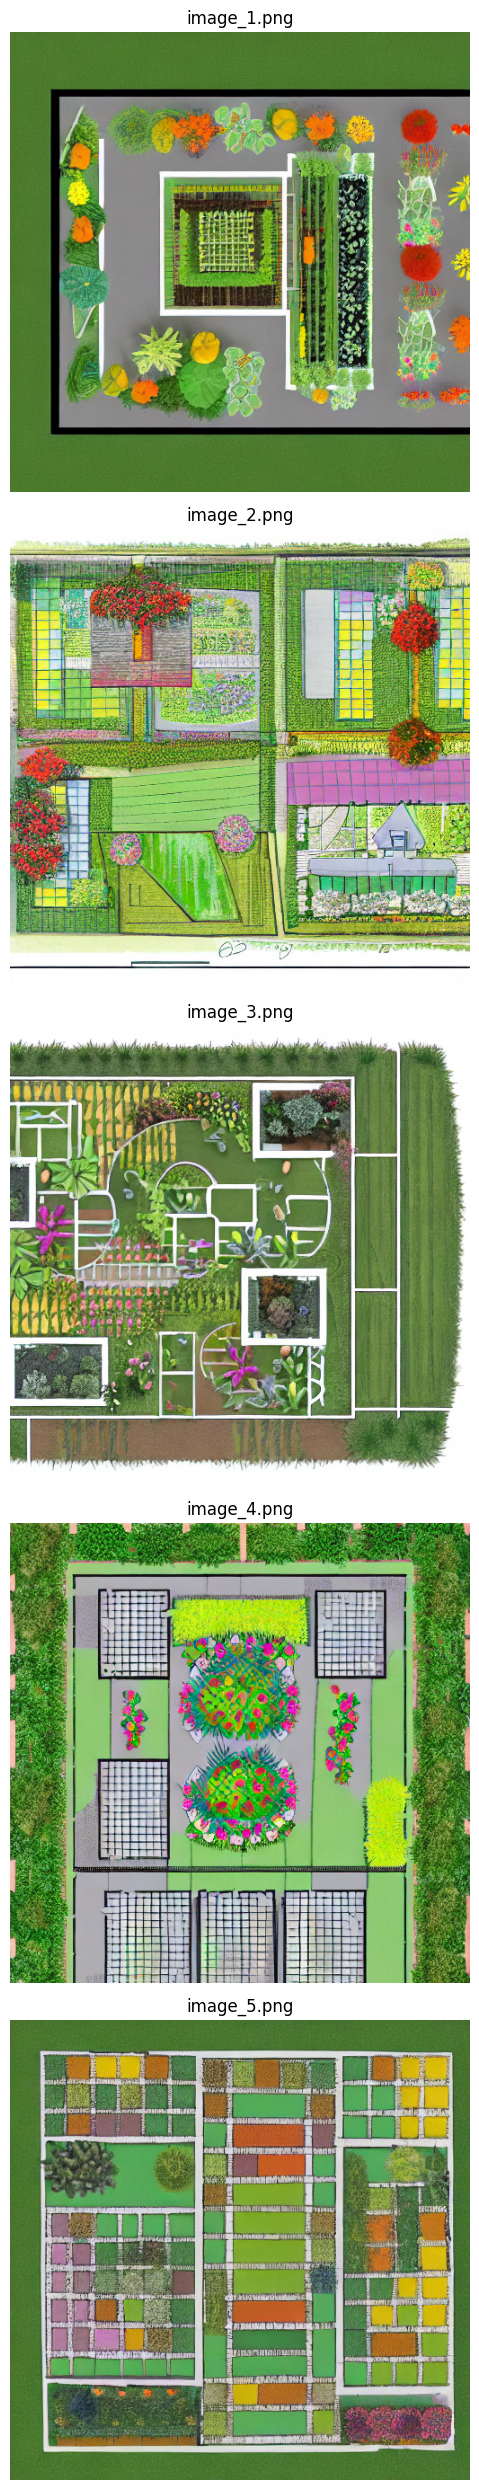


🌱Plantenplan:
 Advies voor Sven's Bohemian Tuin

 1. Introductie van de tuin en de sfeer
De tuin die we voor ogen hebben combineert de organische vormen van een natuurlijke tuin met de nostalgische charme van een klassieke stijl. Door droogtebestendige planten te gebruiken, creëren we een tuin die bestand is tegen het veranderende klimaat en weinig water nodig heeft. De tuin wordt speels en levendig, vol bloemen die kleur en geur brengen en tegelijkertijd bijen en vlinders aantrekken.

We maken gebruik van siergrassen en bloeiende vaste planten die de bohemian uitstraling versterken, en creëren knusse hoekjes met natuurlijke materialen zoals hout en steen.

🌼Combinaties:
 2. Lijst van planten met uitleg

Hieronder een selectie van planten die zowel droogtebestendig zijn als passen bij de stijl en sfeer van je tuin:

1. Veldsalie (Salvia pratensis)  
   - Lichtbehoefte: Volle zon.  
   - Bodem: Goed doorlatende grond.  
   - Onderhoud: Gemiddeld, snoeien na de bloei voor tweede bloei. 

In [47]:
# ---------- Generate and display images ----------
import os
import requests
from io import BytesIO
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

API_URL = "https://5bf7-34-53-57-243.ngrok-free.app"  # jouw ngrok URL
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)  # Zorg dat de map bestaat

def generate_images(prompt):
    response = requests.post(f"{API_URL}/generate", json={"prompt": prompt})
    
    if response.status_code == 200:
        # Lees ZIP bestand in geheugen
        zip_bytes = BytesIO(response.content)
        
        with ZipFile(zip_bytes) as zip_file:
            for file_name in zip_file.namelist():
                # Lees elke afbeelding en sla op in output_dir
                with zip_file.open(file_name) as image_file:
                    img_data = image_file.read()
                    file_path = os.path.join(output_dir, file_name)
                    with open(file_path, "wb") as f:
                        f.write(img_data)
                    # print(f"Afbeelding opgeslagen als {file_path}")
    else:
        print(f"Fout: {response.status_code} - {response.json()}")

if __name__ == "__main__":
    generate_images(visual_descriptions)


output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

# Toegestane afbeelding extensies (alle kleine letters)
image_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".gif", ".tiff", ".webp"}

# Zoek alle afbeeldingsbestanden in de map met ondersteunde extensies
image_files = [
    f for f in os.listdir(output_dir)
    if os.path.splitext(f)[1].lower() in image_extensions
]

if len(image_files) == 0:
    print(f"Geen afbeeldingsbestanden gevonden in map '{output_dir}'.")
else:
    num_images = len(image_files)
    plt.figure(figsize=(10, num_images * 5))  # Hoogte per afbeelding
    
    for i, file_name in enumerate(image_files, start=1):
        img_path = os.path.join(output_dir, file_name)
        img = Image.open(img_path)
        
        plt.subplot(num_images, 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(file_name)
    
    plt.tight_layout()
    plt.show()


# Schoon de tekst op door ongewenste tekens te verwijderen
schoongemaakte_tekst = re.sub(r"[#*]", "", volledige_plantadvies)

# Splits de tekst in volledige_plantadvies op basis van '---'
delen = schoongemaakte_tekst.split('---')

# Toewijzen aan aparte variabelen
# samenvatting = delen[0].strip() if len(delen) > 0 else ""
plantenplan = delen[1].strip() if len(delen) > 1 else ""
combinaties = delen[2].strip() if len(delen) > 2 else ""
klimaat = delen[3].strip() if len(delen) > 3 else ""
plan_van_aanpak = delen[4].strip() if len(delen) > 4 else ""
inspiratie = delen[5].strip() if len(delen) > 5 else ""

# Print de onderdelen netjes
# print("📜Samenvatting:\n", samenvatting)
print("\n🌱Plantenplan:\n", plantenplan)
print("\n🌼Combinaties:\n", combinaties)
print("\n🌤️Klimaat:\n", klimaat)
print("\n🛠️Plan van Aanpak:\n", plan_van_aanpak)
print("\n💡Inspiratie:\n", inspiratie)